In [ ]:
import torch
import torch.nn as nn
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

# 4. Image Classification

Now we have nearly all it takes to train our model.

### Oh, wait - the model? 

## 4.1 Neural Network in PyTorch

There are different ways to define a neural network in PyTorch. Since we start with a small network we stick to a simple method: Creating a pytorch.nn.Module Class!


### Archtiecture

1. Block
- Convolutional Layer (3,3), stride=1, padding=1, output_channels=32
- ReLU
- Convolutional Layer (3,3), stride=1, padding=1, output_channels=32
- ReLU
- MaxPooling (2,2)

2. Block
- Convolutional Layer (3,3), stride=1, padding=1, output_channels=64
- ReLU
- Convolutional Layer (3,3), stride=1, padding=1, output_channels=64
- ReLU
- MaxPooling (2,2)

3. Block
- Fully Connected Linear Layer


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, img_size, num_classes):
        super(SimpleNet, self).__init__()
        self.img_size = img_size

        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()

        # Instantiate two convolutional blocks
        ## Block 1
        self.conv1_1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1)
        ## Block 2
        self.conv2_1 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        ## Block 3
        # Instantiate a fully connected layer
        self.fc = nn.Linear(
            int(img_size[0] / 2 / 2 * img_size[1] / 2 / 2 * 64), num_classes)

    def forward(self, x):
        # Apply block 1 followed by max pool
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool(x)

        # Apply block 2followed by max pool
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, int(64 * 32 / 2 / 2 * 32 / 2 / 2))

        # Apply the fully connected layer and return the result
        return self.fc(x)

### Get Model Instance

In order to do that we first need to know the shape of our images. Therefore we use the same functionallity as before to loas the CIFAR-10 Dataset

In [ ]:
from dlvc.datasets.cifar import Cifar10
from dlvc.dataset import Subset
import dlvc.ops as ops
from dlvc.batches import BatchGenerator

DATA_PATH = "./cifar-10-batches-py/"
train_data = Cifar10(DATA_PATH, Subset.TRAINING)
val_data = Cifar10(DATA_PATH, Subset.VALIDATION)
test_data = Cifar10(DATA_PATH, Subset.TEST)

In [ ]:
op = ops.chain([
    ops.type_cast(np.float32),
    ops.add(-127.5),
    ops.mul(1 / 127.5),
    ops.hwc2chw()
])

train_batches = BatchGenerator(train_data, 128, False, op)
val_batches = BatchGenerator(val_data, 128, False, op)
test_batches = BatchGenerator(test_data, 128, False, op)

In [ ]:
img_shape = train_data.image_shape()
num_classes = train_data.num_classes()

net = SimpleNet(img_shape, num_classes)

In [ ]:
net

SimpleNet(
  (relu): ReLU()
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)

## 4.2 Model Training

In order to train our model we still need to define two things:

1. The Loss Function

We stick to the simple but effective Cross Entropy Loss

2. The Optimizer

You Probably all have heard about Stochastic Gradient Descent (SGD)

### 4.2.1 Cross Entropy Loss

The Cross Entropy Loss, or Log Loss, measures the performance of a classifier which outputs class probabilites for every class

![cnn](images/cross_entropy.png)

[Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

In [ ]:
# load the loss function from PyTorch
criterion = nn.CrossEntropyLoss()

### 4.2.2 Stochastic Gradient Descent

Update the parameters of the network according to the Gradient (Derivation at a certain point).

A lot of information about this - just accept as a fact that this works for now ^^

In [ ]:
learning_rate = 0.01
weight_decay = 0

optimizer = torch.optim.SGD(
            net.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay, 
            nesterov=True, 
            momentum=0.9)


def get_prediction(row):             
    return np.argmax(row)

## Finally, train that boy

Iterate over every batch in the training examples and train the model using the labels

In [ ]:
net.train()

num_correct_predictions = 0
num_predictions = 0
count = 0
for batch in train_batches:
    print("Batch #{}".format(count))
    data = batch.data
    labels = batch.label

    optimizer.zero_grad()

    inputs = torch.from_numpy(data).cpu()
    label = torch.from_numpy(labels).long().cpu()

    outputs = net(inputs)

    loss = criterion(outputs, label)
    loss.backward()

    optimizer.step()
    count += 1

    predictions = np.apply_along_axis(get_prediction, 1, outputs.detach().numpy())
    correct_predictions = np.sum(predictions == labels)
    num_correct_predictions += correct_predictions
    num_predictions += len(predictions)
print("Training Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))

Batch #0
/opt/venv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Batch #1
Batch #2
Batch #3
Batch #4
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Batch #15
Batch #16
Batch #17
Batch #18
Batch #19
Batch #20
Batch #21
Batch #22
Batch #23
Batch #24
Batch #25
Batch #26
Batch #27
Batch #28
Batch #29
Batch #30
Batch #31
Batch #32
Batch #33
Batch #34
Batch #35
Batch #36
Batch #37
Batch #38
Batch #39
Batch #40
Batch #41
Batch #42
Batch #43
Batch #44
Batch #45
Batch #46
Batch #47
Batch #48
Batch #49
Batch #50
Batch #51
Batch #52
Batch #53
Batch #54
Batch #55
Batch #56
Batch #57
Batch #58
Batch #59
Batch #60
Batch #61
Batch #62
Batch 

### Predict Image-Class using the Model

We can now use the model in the same way to predict new images. 

There are slight differences during training and predicting:

- Gradient Calculation is not needed

- Behaviour of certain layers

    e.g.: Dropout Layer

#### Test-Set

For now we use our validation set for this simple test.

In [ ]:
net.eval() # behaviour of layer
num_predictions = 0
num_correct_predictions = 0
with torch.no_grad(): # no gradients
    for batch in val_batches:
        data = batch.data
        labels = batch.label

        inputs = torch.from_numpy(data).cpu()

        outputs = net(inputs)
        predictions = np.apply_along_axis(get_prediction, 1, outputs)
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)

print("Accuracy >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))

Accuracy >>> 47.34%


### Not that bad for a simple network with only one Training Epoch

## Adding more Epochs

This is very simple by just adding a for loop to repeat the training of the network with the same batches.

In [ ]:
EPOCHS = 10

train_accuracies = []
val_accuracies = []

for i in range(EPOCHS-1):
    print("Epoch #{}".format(i+2))
    num_predictions = 0
    num_correct_predictions = 0

    net.train()
    for batch in train_batches:
        data = batch.data
        labels = batch.label

        optimizer.zero_grad()

        inputs = torch.from_numpy(data).cpu()
        label = torch.from_numpy(labels).long().cpu()

        outputs = net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        predictions = np.apply_along_axis(get_prediction, 1, outputs.detach().numpy())
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)
    print("Training Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    train_accuracies.append(num_correct_predictions/num_predictions)
    
    # Validation during training
    num_predictions = 0
    num_correct_predictions = 0

    net.eval()
    with torch.no_grad():
        for val_batch in val_batches:
            data = val_batch.data
            labels = val_batch.label

            inputs = torch.from_numpy(data).cpu()

            outputs = net(inputs)
            predictions = np.apply_along_axis(get_prediction, 1, outputs)
            correct_predictions = np.sum(predictions == labels)
            num_correct_predictions += correct_predictions
            num_predictions += len(predictions)
    print("Validation Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    val_accuracies.append(num_correct_predictions/num_predictions)

Epoch #2
Training Accurcay >>> 53.37%
Validation Accurcay >>> 52.76%
Epoch #3
Training Accurcay >>> 62.39%
Validation Accurcay >>> 61.21%
Epoch #4
Training Accurcay >>> 68.19%
Validation Accurcay >>> 66.55%
Epoch #5
Training Accurcay >>> 71.71%
Validation Accurcay >>> 69.86%
Epoch #6
Training Accurcay >>> 74.66%
Validation Accurcay >>> 71.28%
Epoch #7
Training Accurcay >>> 77.24%
Validation Accurcay >>> 72.04%
Epoch #8
Training Accurcay >>> 79.5%
Validation Accurcay >>> 72.51%
Epoch #9
Training Accurcay >>> 81.33%
Validation Accurcay >>> 72.28%
Epoch #10
Training Accurcay >>> 83.14%
Validation Accurcay >>> 71.63%


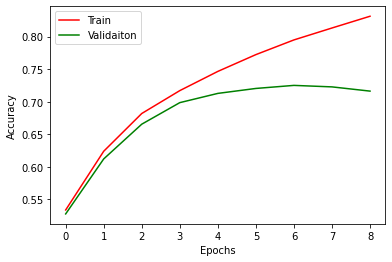

In [ ]:
import matplotlib.pyplot as plt

line1 = plt.plot(train_accuracies, color="r", label="Train")
line2 = plt.plot(val_accuracies, color="g", label="Validaiton")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## And here comes Overfitting

### Data Augmentation to the rescue!


We can reuse the operation chain defined above and add some data augmenatation functions.


1. Shuffle the data every epoch

2. flip image horiontally with 50% probability

3. Crop the images by first padding the borders and then get the same size


(3, 35, 35)


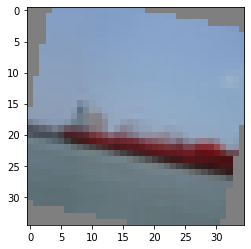

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(3, 35, 35)


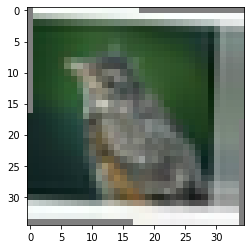

(3, 35, 35)


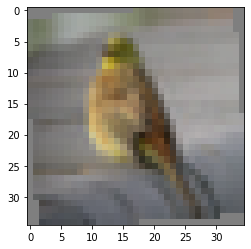

(3, 35, 35)


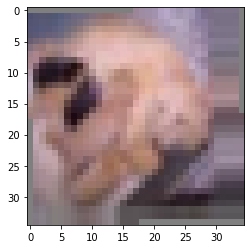

(3, 35, 35)


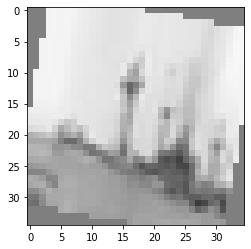

In [ ]:
import dlvc.ops as ops

op_augmentation = ops.chain([
    ops.type_cast(np.float32),
    ops.add(-127.5),
    ops.mul(1 / 127.5),
    ops.hflip(),
    ops.rcrop(35, 5, 'edge'),
    ops.add_noise(),
    ops.rotate_image(),
    ops.hwc2chw()
])

train_batches_augmented = BatchGenerator(train_data, 128, True, op_augmentation)

ops_rev = ops.chain([
    ops.chw2hwc(),
    ops.mul(127.5),
    ops.add(127.5),
    ops.type_cast(np.int64)
])

for batch in train_batches_augmented:
    data = batch.data
    break


for i in range(5):
    plt.figure()
    print(data[i].shape)

    image_original = ops_rev(data[i])
    plt.imshow(image_original)
    plt.show()        


(35, 35, 3)
(35, 35, 3)


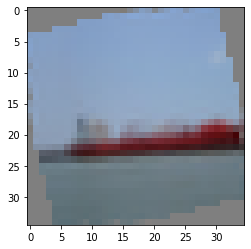

In [ ]:
from scipy.ndimage import rotate

image  = ops_rev(data[0])

new = rotate(data[0], 15, axes=(1,2), reshape=False)

new = ops_rev(new)
print(new.shape)
print(image.shape)

plt.imshow(new)
plt.show()     

In [ ]:
import torchvision.models as models

#augmented_net = models.resnet18(pretrained=True).cuda()


augmented_net = SimpleNet(img_shape, num_classes)

optimizer = torch.optim.SGD(
            augmented_net.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay, 
            nesterov=True, 
            momentum=0.9)


EPOCHS = 70

train_accuracies = []
val_accuracies = []

for i in range(EPOCHS):
    print("Epoch #{}".format(i+1))
    num_predictions = 0
    num_correct_predictions = 0

    augmented_net.train()
    for batch in train_batches_augmented:
        data = batch.data
        labels = batch.label

        optimizer.zero_grad()

        inputs = torch.from_numpy(data).cpu()
        label = torch.from_numpy(labels).long().cpu()

        outputs = augmented_net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        predictions = np.apply_along_axis(get_prediction, 1, outputs.detach().numpy())
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)
    print("Training Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    train_accuracies.append(num_correct_predictions/num_predictions)
    
    # Validation during training
    num_predictions = 0
    num_correct_predictions = 0

    augmented_net.eval()
    with torch.no_grad():
        for val_batch in val_batches:
            data = val_batch.data
            labels = val_batch.label

            inputs = torch.from_numpy(data).cpu()

            outputs = augmented_net(inputs)
            predictions = np.apply_along_axis(get_prediction, 1, outputs)
            correct_predictions = np.sum(predictions == labels)
            num_correct_predictions += correct_predictions
            num_predictions += len(predictions)
    print("Validation Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    val_accuracies.append(num_correct_predictions/num_predictions)

Epoch #1
Training Accurcay >>> 31.53%
Validation Accurcay >>> 43.06%
Epoch #2
Training Accurcay >>> 48.32%
Validation Accurcay >>> 51.56%
Epoch #3
Training Accurcay >>> 55.34%
Validation Accurcay >>> 58.28%
Epoch #4
Training Accurcay >>> 61.11%
Validation Accurcay >>> 62.89%
Epoch #5
Training Accurcay >>> 64.95%
Validation Accurcay >>> 64.58%
Epoch #6
Training Accurcay >>> 67.39%
Validation Accurcay >>> 67.82%
Epoch #7
Training Accurcay >>> 69.55%
Validation Accurcay >>> 69.21%
Epoch #8
Training Accurcay >>> 71.08%
Validation Accurcay >>> 70.35%
Epoch #9
Training Accurcay >>> 72.37%
Validation Accurcay >>> 70.95%
Epoch #10
Training Accurcay >>> 73.35%
Validation Accurcay >>> 72.18%
Epoch #11
Training Accurcay >>> 74.44%
Validation Accurcay >>> 73.07%
Epoch #12
Training Accurcay >>> 75.1%
Validation Accurcay >>> 73.15%
Epoch #13
Training Accurcay >>> 76.09%
Validation Accurcay >>> 74.38%
Epoch #14
Training Accurcay >>> 76.69%
Validation Accurcay >>> 74.79%
Epoch #15
Training Accurcay >>

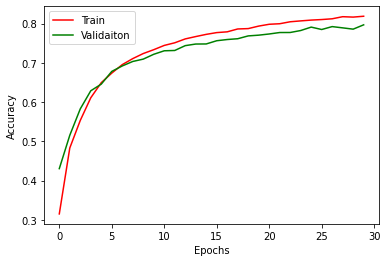

In [ ]:
line1 = plt.plot(train_accuracies, color="r", label="Train")
line2 = plt.plot(val_accuracies, color="g", label="Validaiton")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
import torchvision.models as models

augmented_net = models.resnet18(pretrained=True)

optimizer = torch.optim.SGD(
            augmented_net.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay, 
            nesterov=True, 
            momentum=0.9)


EPOCHS = 30

train_accuracies = []
val_accuracies = []

for i in range(EPOCHS):
    print("Epoch #{}".format(i+1))
    num_predictions = 0
    num_correct_predictions = 0

    augmented_net.train()
    for batch in train_batches_augmented:
        data = batch.data
        labels = batch.label

        optimizer.zero_grad()

        inputs = torch.from_numpy(data).cpu()
        label = torch.from_numpy(labels).long().cpu()

        outputs = augmented_net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        predictions = np.apply_along_axis(get_prediction, 1, outputs.detach().numpy())
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)
    print("Training Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    train_accuracies.append(num_correct_predictions/num_predictions)
    
    # Validation during training
    num_predictions = 0
    num_correct_predictions = 0

    augmented_net.eval()
    with torch.no_grad():
        for val_batch in val_batches:
            data = val_batch.data
            labels = val_batch.label

            inputs = torch.from_numpy(data).cpu()

            outputs = augmented_net(inputs)
            predictions = np.apply_along_axis(get_prediction, 1, outputs)
            correct_predictions = np.sum(predictions == labels)
            num_correct_predictions += correct_predictions
            num_predictions += len(predictions)
    print("Validation Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    val_accuracies.append(num_correct_predictions/num_predictions)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


NameError: name 'torch' is not defined

In [ ]:
line1 = plt.plot(train_accuracies, color="r", label="Train")
line2 = plt.plot(val_accuracies, color="g", label="Validaiton")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
net.eval() # behaviour of layer

num_predictions = 0
num_correct_predictions = 0
with torch.no_grad(): # no gradients
    for batch in test_batches:
        data = batch.data
        labels = batch.label

        inputs = torch.from_numpy(data).cpu()

        outputs = net(inputs)
        predictions = np.apply_along_axis(get_prediction, 1, outputs)
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)

print("Accuracy >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))